# Using RL to Model Cognitive Tasks

**By Neurmatch Academy**

__Content creators:__ Morteza Ansarinia, Yamil Vidal

__Production editor:__ Spiros Chavlis


<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.




---
# Setup

In [15]:
# @title Install dependencies
# !pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax,tensorflow] --quiet
!pip install dm-acme[envs] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet

In [16]:
# Imports

import time
import numpy as np
import pandas as pd
import sonnet as snt
import seaborn as sns
import matplotlib.pyplot as plt

import dm_env

import acme
from acme import specs
from acme import wrappers
from acme import EnvironmentLoop
from acme.agents.tf import dqn
from acme.utils import loggers

In [17]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.

## N-back task

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

---
# Cognitive Tests Environment

First we develop an environment in that agents perform a cognitive test, here the N-back.

## Human dataset

We need a dataset of human perfoming a N-back test, with the following features:

- `participant_id`: following the BIDS format, it contains a unique identifier for each participant.
- `trial_index`: same as `time_step`.
- `stimulus`: same as `observation`.
- `response`: same as `action`, recorded response by the human subject.
- `expected_response`: correct response.
- `is_correct`: same as `reward`, whether the human subject responded correctly.
- `response_time`: won't be used here.

Here we generate a mock dataset with those features, but remember to **replace this with real human data.**

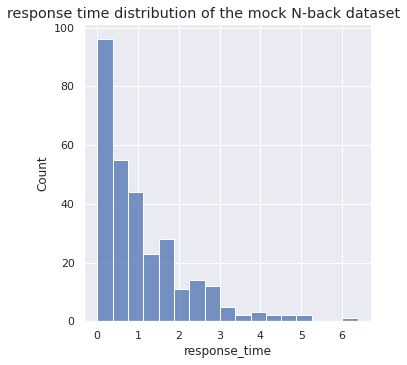

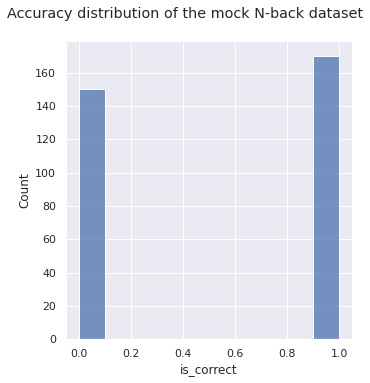

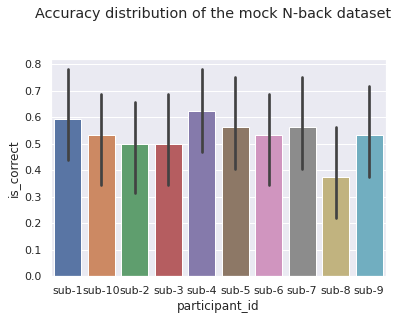

,participant_id,trial_index,stimulus,response,response_time,expected_response,is_correct
0,sub-1,1,D,None,NaN,None,1
1,sub-1,2,F,None,NaN,None,1
2,sub-1,3,D,match,2.930082,match,1
3,sub-1,4,B,match,2.384095,non-match,0
4,sub-1,5,F,match,2.336254,non-match,0


In [18]:
def generate_mock_nback_dataset(N=2,
                                n_participants=10,
                                n_trials=32,
                                stimulus_choices=list('ABCDEF'),
                                response_choices=['match', 'non-match']):
  """Generate a mock dataset for the N-back task."""

  n_rows = n_participants * n_trials

  participant_ids = sorted([f'sub-{pid}' for pid in range(1, n_participants + 1)] * n_trials)
  trial_indices = list(range(1, n_trials + 1)) * n_participants
  stimulus_sequence = np.random.choice(stimulus_choices, n_rows)

  responses = np.random.choice(response_choices, n_rows)
  response_times = np.random.exponential(size=n_rows)

  df = pd.DataFrame({
      'participant_id': participant_ids,
      'trial_index': trial_indices,
      'stimulus': stimulus_sequence,
      'response': responses,
      'response_time': response_times
  })

  # mark matchig stimuli
  _nback_stim = df['stimulus'].shift(N)
  df['expected_response'] = (df['stimulus'] == _nback_stim).map({True: 'match', False: 'non-match'})

  df['is_correct'] = (df['response'] == df['expected_response'])

  # we don't care about burn-in trials (trial < N)
  df.loc[df['trial_index'] <= N, 'is_correct'] = True
  df.loc[df['trial_index'] <= N, ['response', 'response_time', 'expected_response']] = None

  return df


# ========
# now generate the actual data with the provided function and plot some of its features
mock_nback_data = generate_mock_nback_dataset()
mock_nback_data['is_correct'] = mock_nback_data['is_correct'].astype(int)

sns.displot(data=mock_nback_data, x='response_time')
plt.suptitle('response time distribution of the mock N-back dataset', y=1.01)
plt.show()

sns.displot(data=mock_nback_data, x='is_correct')
plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
plt.show()

sns.barplot(data=mock_nback_data, y='is_correct', x='participant_id')
plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
plt.show()

mock_nback_data.head()

## Implementation scheme


### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [26]:
class NBack(dm_env.Environment):

  ACTIONS = ['match', 'non-match']

  def __init__(self,
               N=2,
               episode_steps=32,
               stimuli_choices=list('ABCDEF'),
               human_data=None,
               seed=1,
               ):
    """
    Args:
      N: Number of steps to look back for the matched stimuli. Defaults to 2 (as in 2-back).
      episode_steps
      stimuli_choices
      human_data
      seed

    """
    # N back =2
    self.N = N
    # Number of episode steps = 32
    self.episode_steps = episode_steps
    # Stimuli choices = 0,1,2,3,4,5
    self.stimuli_choices = stimuli_choices
    # Stimuli - vector of size 32
    self.stimuli = np.empty(shape=episode_steps)  # will be filled in the `reset()`
    
    self.n_s = len(self.stimuli_choices)
    self.prob = 0.5 * (self.n_s - 2)/ (self.n_s - 1)


    self._reset_next_step = True

    # whether mimic humans or reward the agent once it responds optimally.
    if human_data is None:
      self._imitate_human = False
      self.human_data = None
      self.human_subject_data = None
    else:
      self._imitate_human = True
      self.human_data = human_data
      self.human_subject_data = None

    # Action History is a plank vector
    self._action_history = []

  def reset(self):
    self._reset_next_step = False
    self._current_step = 0
    self._action_history.clear()

    # generate a random sequence instead of relying on human data
    # generates an entire random sequence of 32 stimuli [................................]
    if self.human_data is None:
      # self.stimuli = np.random.choice(self.stimuli_choices, self.episode_steps)
      # FIXME This is a fix for acme & reverb issue with string observation. Agent should be able to handle strings
      #self.stimuli = np.random.choice(len(self.stimuli_choices), self.episode_steps).astype(np.float32)
      #self.stimuli = np.random.choice(len(self.stimuli_choices)).astype(np.float32)
      #print("self.stimuli", self.stimuli)

      self.stimuli=np.ones(self.episode_steps)
      # match prob will be slightly higher than non-match prob
      for i in range(self.episode_steps):
          if i<self.N:
            self.stimuli[i]=np.random.choice(self.n_s)
          else:
            rand=np.random.random()
            if rand < self.prob:
              self.stimuli[i]=self.stimuli[i-self.N]
            else:
              self.stimuli[i]=np.random.choice(self.n_s)

   
    else:
      # randomly choose a subject from the human data and follow her trials and responses.
      # FIXME should we always use one specific human subject or randomly select one in each episode?
      self.human_subject_data = self.human_data.query('participant_id == participant_id.sample().iloc[0]',
                                                engine='python').sort_values('trial_index')
      self.stimuli = self.human_subject_data['stimulus'].to_list()
      self.stimuli = np.array([ord(s) - ord('A') + 1 for s in self.stimuli]).astype(np.float32)

    # return the observation 
    return dm_env.restart(self._observation())


  def _episode_return(self):
    if self._imitate_human:
      return np.mean(self.human_subject_data['response'] == self._action_history)
    else:
      return 0.0

  def step(self, action: int):
    if self._reset_next_step:
      return self.reset()

    agent_action = NBack.ACTIONS[action]
    #print("Step action" , agent_action)

    if self._imitate_human:
      # if it was the same action as the human subject, then reward the agent
      human_action = self.human_subject_data['response'].iloc[self._current_step]
      step_reward = 0. if (agent_action == human_action) else -1.
    else:
      # assume the agent is rationale and doesn't want to reproduce human, reward once the response it correct
      # gives a reward based on the action chosen by the agent but it has access to all the stimuli 
      #print("Current Stimuli for reward", self.stimuli[self._current_step])
      expected_action = 'match' if (self.stimuli[self._current_step] == self.stimuli[self._current_step - self.N]) else 'non-match'
      step_reward = 0. if (agent_action == expected_action) else -1.
      #print("reward")

    self._action_history.append(agent_action)

    self._current_step += 1

    # Check for termination.
    if self._current_step == self.stimuli.shape[0]:
      self._reset_next_step = True
      # we are using the mean of total time step rewards as the episode return
      return dm_env.termination(reward=self._episode_return(),
                                observation=self._observation())
    else:
      return dm_env.transition(reward=step_reward,
                               observation=self._observation())

  def observation_spec(self):
    return dm_env.specs.BoundedArray(
        shape=self.stimuli[0].shape,
        dtype=self.stimuli[0].dtype,
        name='nback_stimuli', minimum=0, maximum=len(self.stimuli_choices)+ 1)

  def action_spec(self):
    return dm_env.specs.DiscreteArray(
        num_values=len(NBack.ACTIONS),
        dtype=np.int32,
        name='action')

  def _observation(self):

    # agent observes only the current trial
    #print("\nCurrent Step",self._current_step)

    if self._current_step ==  self.episode_steps:
      obs = self.stimuli[0]
    else:
      obs = self.stimuli[self._current_step]
    #print("Observation",obs)
    # agents observe stimuli up to the current trial
    #obs = self.stimuli[:self._current_step+1].copy()
    #obs = np.pad(obs,(0, len(self.stimuli) - len(obs)))
  
    return obs

  def plot_state(self):
    """Display current state of the environment.

     Note: `M` mean `match`, and `.` is a `non-match`.
    """
    stimuli = self.stimuli[:self._current_step - 1]
    actions = ['M' if a=='match' else '.' for a in self._action_history[:self._current_step - 1]]
    return HTML(
        f'<b>Environment ({self.N}-back):</b><br />'
        f'<pre><b>Stimuli:</b> {"".join(map(str,map(int,stimuli)))}</pre>'
        f'<pre><b>Actions:</b> {"".join(actions)}</pre>'
    )

  @staticmethod
  def create_environment():
    """Utility function to create a N-back environment and its spec."""

    # Make sure the environment outputs single-precision floats.
    environment = wrappers.SinglePrecisionWrapper(NBack())

    # Grab the spec of the environment.
    environment_spec = specs.make_environment_spec(environment)

    return environment, environment_spec

### Define a random agent

For more information you can refer to NMA-DL W3D2 Basic Reinforcement learning.

In [23]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

### Initialize the environment and the agent

In [27]:
env, env_spec = NBack.create_environment()
agent = RandomAgent(env_spec)

print('actions:\n', env_spec.actions)
print('observations:\n', env_spec.observations)
print('rewards:\n', env_spec.rewards)

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=1, num_values=2)
observations:
 BoundedArray(shape=(), dtype=dtype('float32'), name='nback_stimuli', minimum=0.0, maximum=7.0)
rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


### Run the loop

For more details, see NMA-DL W3D2.

In [ ]:
# fitting parameters
n_episodes = 3000
n_total_steps = 0
log_loss = False
n_steps = n_episodes * 32
all_returns = []

# main loop
for episode in range(n_episodes):
  episode_steps = 0
  episode_return = 0
  episode_loss = 0

  start_time = time.time()

  timestep = env.reset() 

  # Make the first observation.
  agent.observe_first(timestep)

  # Run an episode
  while not timestep.last():

    # DEBUG
    # print(timestep)

    # Generate an action from the agent's policy and step the environment.
    #print("get observation", timestep.observation)
    action = agent.select_action(timestep.observation)
    #print("get action:", action)
    timestep = env.step(action)
    #print("take a step")

    # Have the agent observe the timestep and let the agent update itself.
    agent.observe(action, next_timestep=timestep)
    #print("timestep", timestep)
    agent.update()
  

    # Book-keeping.
    episode_steps += 1
    n_total_steps += 1
    episode_return += timestep.reward

    if log_loss:
      episode_loss += agent.last_loss

    if n_steps is not None and n_total_steps > n_steps:
      break

  # Collect the results and combine with counts.
  steps_per_second = episode_steps / (time.time() - start_time)
  result = {
      'episode': episode,
      'episode_length': episode_steps,
      'episode_return': episode_return,
  }
  if log_loss:
    result['loss_avg'] = episode_loss/episode_steps

  all_returns.append(episode_return)

  display(env.plot_state())
  # Log the given results.
  print(result)

  if n_steps is not None and n_total_steps >= n_steps:
    break

clear_output()

# Histogram of all returns
plt.figure()
sns.histplot(all_returns, stat="density", kde=True, bins=12)
plt.xlabel('Return [a.u.]')
plt.ylabel('Density')
plt.show()

{'episode': 0, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 2, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 3, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 4, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 5, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 6, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 7, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 8, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 9, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 10, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 11, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 12, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 13, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 14, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 15, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 16, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 17, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 18, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 19, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 20, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 21, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 22, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 23, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 24, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 25, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 26, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 27, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 28, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 29, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 30, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 31, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 32, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 33, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 34, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 35, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 36, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 37, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 38, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 39, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 40, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 41, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 42, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 43, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 44, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 45, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 46, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 47, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 48, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 49, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 50, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 51, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 52, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 53, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 54, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 55, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 56, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 57, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 58, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 59, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 60, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 61, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 62, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 63, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 64, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 65, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 66, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 67, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 68, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 69, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 70, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 71, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 72, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 73, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 74, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 75, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 76, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 77, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 78, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 79, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 80, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 81, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 82, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 83, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 84, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 85, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 86, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 87, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 88, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 89, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 90, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 91, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 92, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 93, 'episode_length': 32, 'episode_return': -23.0}


{'episode': 94, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 95, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 96, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 97, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 98, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 99, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 100, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 101, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 102, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 103, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 104, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 105, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 106, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 107, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 108, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 109, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 110, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 111, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 112, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 113, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 114, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 115, 'episode_length': 32, 'episode_return': -24.0}


{'episode': 116, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 117, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 118, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 119, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 120, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 121, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 122, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 123, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 124, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 125, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 126, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 127, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 128, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 129, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 130, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 131, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 132, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 133, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 134, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 135, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 136, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 137, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 138, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 139, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 140, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 141, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 142, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 143, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 144, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 145, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 146, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 147, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 148, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 149, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 150, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 151, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 152, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 153, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 154, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 155, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 156, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 157, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 158, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 159, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 160, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 161, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 162, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 163, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 164, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 165, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 166, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 167, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 168, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 169, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 170, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 171, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 172, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 173, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 174, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 175, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 176, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 177, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 178, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 179, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 180, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 181, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 182, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 183, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 184, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 185, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 186, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 187, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 188, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 189, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 190, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 191, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 192, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 193, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 194, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 195, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 196, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 197, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 198, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 199, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 200, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 201, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 202, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 203, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 204, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 205, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 206, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 207, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 208, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 209, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 210, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 211, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 212, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 213, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 214, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 215, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 216, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 217, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 218, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 219, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 220, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 221, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 222, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 223, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 224, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 225, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 226, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 227, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 228, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 229, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 230, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 231, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 232, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 233, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 234, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 235, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 236, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 237, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 238, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 239, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 240, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 241, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 242, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 243, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 244, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 245, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 246, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 247, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 248, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 249, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 250, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 251, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 252, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 253, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 254, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 255, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 256, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 257, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 258, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 259, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 260, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 261, 'episode_length': 32, 'episode_return': -7.0}


{'episode': 262, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 263, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 264, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 265, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 266, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 267, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 268, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 269, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 270, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 271, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 272, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 273, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 274, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 275, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 276, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 277, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 278, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 279, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 280, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 281, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 282, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 283, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 284, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 285, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 286, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 287, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 288, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 289, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 290, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 291, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 292, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 293, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 294, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 295, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 296, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 297, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 298, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 299, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 300, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 301, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 302, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 303, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 304, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 305, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 306, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 307, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 308, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 309, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 310, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 311, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 312, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 313, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 314, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 315, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 316, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 317, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 318, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 319, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 320, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 321, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 322, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 323, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 324, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 325, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 326, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 327, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 328, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 329, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 330, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 331, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 332, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 333, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 334, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 335, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 336, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 337, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 338, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 339, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 340, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 341, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 342, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 343, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 344, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 345, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 346, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 347, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 348, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 349, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 350, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 351, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 352, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 353, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 354, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 355, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 356, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 357, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 358, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 359, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 360, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 361, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 362, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 363, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 364, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 365, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 366, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 367, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 368, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 369, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 370, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 371, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 372, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 373, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 374, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 375, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 376, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 377, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 378, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 379, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 380, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 381, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 382, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 383, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 384, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 385, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 386, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 387, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 388, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 389, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 390, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 391, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 392, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 393, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 394, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 395, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 396, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 397, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 398, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 399, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 400, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 401, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 402, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 403, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 404, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 405, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 406, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 407, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 408, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 409, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 410, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 411, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 412, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 413, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 414, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 415, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 416, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 417, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 418, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 419, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 420, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 421, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 422, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 423, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 424, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 425, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 426, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 427, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 428, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 429, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 430, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 431, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 432, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 433, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 434, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 435, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 436, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 437, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 438, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 439, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 440, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 441, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 442, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 443, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 444, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 445, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 446, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 447, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 448, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 449, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 450, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 451, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 452, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 453, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 454, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 455, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 456, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 457, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 458, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 459, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 460, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 461, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 462, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 463, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 464, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 465, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 466, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 467, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 468, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 469, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 470, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 471, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 472, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 473, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 474, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 475, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 476, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 477, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 478, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 479, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 480, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 481, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 482, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 483, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 484, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 485, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 486, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 487, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 488, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 489, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 490, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 491, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 492, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 493, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 494, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 495, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 496, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 497, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 498, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 499, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 500, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 501, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 502, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 503, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 504, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 505, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 506, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 507, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 508, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 509, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 510, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 511, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 512, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 513, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 514, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 515, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 516, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 517, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 518, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 519, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 520, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 521, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 522, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 523, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 524, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 525, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 526, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 527, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 528, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 529, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 530, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 531, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 532, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 533, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 534, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 535, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 536, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 537, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 538, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 539, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 540, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 541, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 542, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 543, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 544, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 545, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 546, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 547, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 548, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 549, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 550, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 551, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 552, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 553, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 554, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 555, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 556, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 557, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 558, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 559, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 560, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 561, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 562, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 563, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 564, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 565, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 566, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 567, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 568, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 569, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 570, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 571, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 572, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 573, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 574, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 575, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 576, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 577, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 578, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 579, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 580, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 581, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 582, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 583, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 584, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 585, 'episode_length': 32, 'episode_return': -23.0}


{'episode': 586, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 587, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 588, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 589, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 590, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 591, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 592, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 593, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 594, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 595, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 596, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 597, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 598, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 599, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 600, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 601, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 602, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 603, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 604, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 605, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 606, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 607, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 608, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 609, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 610, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 611, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 612, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 613, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 614, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 615, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 616, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 617, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 618, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 619, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 620, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 621, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 622, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 623, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 624, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 625, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 626, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 627, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 628, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 629, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 630, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 631, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 632, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 633, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 634, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 635, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 636, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 637, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 638, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 639, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 640, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 641, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 642, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 643, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 644, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 645, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 646, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 647, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 648, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 649, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 650, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 651, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 652, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 653, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 654, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 655, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 656, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 657, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 658, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 659, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 660, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 661, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 662, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 663, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 664, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 665, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 666, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 667, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 668, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 669, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 670, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 671, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 672, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 673, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 674, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 675, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 676, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 677, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 678, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 679, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 680, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 681, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 682, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 683, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 684, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 685, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 686, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 687, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 688, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 689, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 690, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 691, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 692, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 693, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 694, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 695, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 696, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 697, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 698, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 699, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 700, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 701, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 702, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 703, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 704, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 705, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 706, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 707, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 708, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 709, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 710, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 711, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 712, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 713, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 714, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 715, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 716, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 717, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 718, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 719, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 720, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 721, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 722, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 723, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 724, 'episode_length': 32, 'episode_return': -7.0}


{'episode': 725, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 726, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 727, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 728, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 729, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 730, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 731, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 732, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 733, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 734, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 735, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 736, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 737, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 738, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 739, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 740, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 741, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 742, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 743, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 744, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 745, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 746, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 747, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 748, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 749, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 750, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 751, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 752, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 753, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 754, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 755, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 756, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 757, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 758, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 759, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 760, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 761, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 762, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 763, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 764, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 765, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 766, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 767, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 768, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 769, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 770, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 771, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 772, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 773, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 774, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 775, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 776, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 777, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 778, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 779, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 780, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 781, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 782, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 783, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 784, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 785, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 786, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 787, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 788, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 789, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 790, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 791, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 792, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 793, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 794, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 795, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 796, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 797, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 798, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 799, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 800, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 801, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 802, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 803, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 804, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 805, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 806, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 807, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 808, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 809, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 810, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 811, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 812, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 813, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 814, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 815, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 816, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 817, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 818, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 819, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 820, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 821, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 822, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 823, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 824, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 825, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 826, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 827, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 828, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 829, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 830, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 831, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 832, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 833, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 834, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 835, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 836, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 837, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 838, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 839, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 840, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 841, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 842, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 843, 'episode_length': 32, 'episode_return': -23.0}


{'episode': 844, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 845, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 846, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 847, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 848, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 849, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 850, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 851, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 852, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 853, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 854, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 855, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 856, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 857, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 858, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 859, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 860, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 861, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 862, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 863, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 864, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 865, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 866, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 867, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 868, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 869, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 870, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 871, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 872, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 873, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 874, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 875, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 876, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 877, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 878, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 879, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 880, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 881, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 882, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 883, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 884, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 885, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 886, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 887, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 888, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 889, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 890, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 891, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 892, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 893, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 894, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 895, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 896, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 897, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 898, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 899, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 900, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 901, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 902, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 903, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 904, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 905, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 906, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 907, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 908, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 909, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 910, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 911, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 912, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 913, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 914, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 915, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 916, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 917, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 918, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 919, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 920, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 921, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 922, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 923, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 924, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 925, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 926, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 927, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 928, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 929, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 930, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 931, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 932, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 933, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 934, 'episode_length': 32, 'episode_return': -23.0}


{'episode': 935, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 936, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 937, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 938, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 939, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 940, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 941, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 942, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 943, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 944, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 945, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 946, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 947, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 948, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 949, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 950, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 951, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 952, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 953, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 954, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 955, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 956, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 957, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 958, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 959, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 960, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 961, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 962, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 963, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 964, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 965, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 966, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 967, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 968, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 969, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 970, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 971, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 972, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 973, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 974, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 975, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 976, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 977, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 978, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 979, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 980, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 981, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 982, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 983, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 984, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 985, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 986, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 987, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 988, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 989, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 990, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 991, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 992, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 993, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 994, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 995, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 996, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 997, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 998, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 999, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1000, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1001, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1002, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1003, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1004, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1005, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1006, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1007, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1008, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1009, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1010, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1011, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1012, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1013, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1014, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1015, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1016, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1017, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1018, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1019, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1020, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1021, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1022, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1023, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1024, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1025, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1026, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1027, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1028, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1029, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1030, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1031, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1032, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 1033, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1034, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1035, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1036, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1037, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1038, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1039, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1040, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1041, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1042, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1043, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1044, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1045, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1046, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1047, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1048, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1049, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1050, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1051, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1052, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1053, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1054, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1055, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1056, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1057, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1058, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1059, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1060, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1061, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1062, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1063, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1064, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1065, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1066, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1067, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1068, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1069, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1070, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1071, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1072, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1073, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1074, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1075, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1076, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1077, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1078, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1079, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1080, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1081, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1082, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1083, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1084, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1085, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1086, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1087, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1088, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1089, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1090, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1091, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1092, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1093, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1094, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1095, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1096, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1097, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1098, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1099, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1100, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1101, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1102, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1103, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1104, 'episode_length': 32, 'episode_return': -24.0}


{'episode': 1105, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1106, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1107, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1108, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1109, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1110, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1111, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1112, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1113, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1114, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1115, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1116, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1117, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1118, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1119, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1120, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1121, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1122, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1123, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1124, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1125, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1126, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1127, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1128, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1129, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1130, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1131, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1132, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1133, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1134, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1135, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1136, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1137, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1138, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1139, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1140, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1141, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1142, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1143, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1144, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1145, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1146, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1147, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1148, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1149, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1150, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1151, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1152, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1153, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1154, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1155, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1156, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1157, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1158, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1159, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1160, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1161, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1162, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1163, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1164, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1165, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1166, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1167, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1168, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1169, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1170, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1171, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1172, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1173, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1174, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1175, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1176, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1177, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1178, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1179, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1180, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1181, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1182, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1183, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1184, 'episode_length': 32, 'episode_return': -23.0}


{'episode': 1185, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1186, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1187, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1188, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1189, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1190, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1191, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1192, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1193, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1194, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1195, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1196, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1197, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1198, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1199, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1200, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1201, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1202, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1203, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1204, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1205, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1206, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1207, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1208, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1209, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1210, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1211, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1212, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1213, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1214, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1215, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1216, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1217, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1218, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1219, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1220, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1221, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1222, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1223, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1224, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1225, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1226, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1227, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1228, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1229, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1230, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1231, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1232, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1233, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1234, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1235, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1236, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 1237, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1238, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1239, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1240, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1241, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1242, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1243, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1244, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1245, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1246, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1247, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1248, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1249, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1250, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1251, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1252, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1253, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1254, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1255, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1256, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1257, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1258, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1259, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1260, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1261, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1262, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1263, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1264, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1265, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1266, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1267, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1268, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1269, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1270, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1271, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1272, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1273, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1274, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1275, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1276, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1277, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1278, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1279, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1280, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1281, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1282, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1283, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1284, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1285, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1286, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1287, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1288, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1289, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1290, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1291, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1292, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1293, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1294, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1295, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1296, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1297, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1298, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1299, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1300, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1301, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1302, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1303, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1304, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1305, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1306, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1307, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1308, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1309, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1310, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1311, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1312, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1313, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1314, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1315, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1316, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1317, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1318, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1319, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1320, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1321, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1322, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1323, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1324, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1325, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1326, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1327, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1328, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1329, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1330, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1331, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1332, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1333, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1334, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1335, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1336, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1337, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1338, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1339, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1340, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1341, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1342, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1343, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1344, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1345, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1346, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1347, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1348, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1349, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1350, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1351, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1352, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1353, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1354, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1355, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1356, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1357, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1358, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1359, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1360, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1361, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1362, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1363, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1364, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1365, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1366, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1367, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1368, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1369, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1370, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1371, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1372, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1373, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1374, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1375, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1376, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1377, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1378, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1379, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1380, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1381, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1382, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1383, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1384, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1385, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1386, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1387, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1388, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1389, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1390, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1391, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1392, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1393, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1394, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1395, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1396, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1397, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1398, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1399, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1400, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1401, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1402, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1403, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1404, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1405, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1406, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1407, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1408, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1409, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1410, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1411, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1412, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1413, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1414, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1415, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1416, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1417, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1418, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1419, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1420, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1421, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1422, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1423, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1424, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1425, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1426, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1427, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1428, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1429, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1430, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1431, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1432, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1433, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1434, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1435, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1436, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1437, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1438, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1439, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1440, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1441, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1442, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1443, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1444, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1445, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1446, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1447, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1448, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1449, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1450, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1451, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1452, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1453, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1454, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1455, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1456, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1457, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 1458, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1459, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1460, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1461, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1462, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1463, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1464, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1465, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1466, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1467, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1468, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1469, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1470, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1471, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1472, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1473, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1474, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1475, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1476, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1477, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1478, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1479, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1480, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1481, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1482, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1483, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1484, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1485, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1486, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1487, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1488, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1489, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1490, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1491, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1492, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1493, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1494, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1495, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1496, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1497, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1498, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1499, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1500, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1501, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1502, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1503, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1504, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1505, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1506, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1507, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1508, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1509, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1510, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1511, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1512, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1513, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1514, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1515, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1516, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1517, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1518, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1519, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1520, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1521, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1522, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1523, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1524, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1525, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1526, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1527, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1528, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1529, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1530, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1531, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1532, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1533, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1534, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1535, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1536, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1537, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1538, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1539, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1540, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1541, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1542, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1543, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1544, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 1545, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1546, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1547, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1548, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1549, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1550, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1551, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1552, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1553, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1554, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1555, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1556, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1557, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1558, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1559, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1560, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1561, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1562, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1563, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1564, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1565, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1566, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1567, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1568, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1569, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1570, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1571, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1572, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1573, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1574, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1575, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1576, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1577, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1578, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1579, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1580, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1581, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1582, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1583, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1584, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1585, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1586, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1587, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1588, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1589, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1590, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1591, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1592, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1593, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1594, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1595, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1596, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1597, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1598, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1599, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1600, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1601, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1602, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1603, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1604, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1605, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1606, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1607, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1608, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1609, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1610, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1611, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1612, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1613, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1614, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1615, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1616, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1617, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1618, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1619, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1620, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1621, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1622, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1623, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1624, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1625, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1626, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1627, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1628, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1629, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1630, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1631, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1632, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1633, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1634, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1635, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1636, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1637, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1638, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1639, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1640, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1641, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1642, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1643, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1644, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1645, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1646, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1647, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1648, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1649, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1650, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1651, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1652, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1653, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1654, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1655, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1656, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1657, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1658, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1659, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1660, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1661, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1662, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1663, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1664, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1665, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1666, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1667, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1668, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1669, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1670, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1671, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1672, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1673, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1674, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1675, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1676, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1677, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1678, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1679, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1680, 'episode_length': 32, 'episode_return': -23.0}


{'episode': 1681, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1682, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1683, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1684, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1685, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1686, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1687, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1688, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1689, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1690, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1691, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1692, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1693, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1694, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1695, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1696, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1697, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1698, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1699, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1700, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1701, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1702, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1703, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1704, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1705, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1706, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1707, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1708, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1709, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1710, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1711, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1712, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1713, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1714, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1715, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1716, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1717, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1718, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1719, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1720, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1721, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1722, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1723, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1724, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1725, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1726, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1727, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1728, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1729, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1730, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1731, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1732, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1733, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1734, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1735, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1736, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1737, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1738, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1739, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1740, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1741, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1742, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1743, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1744, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1745, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1746, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1747, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1748, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1749, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1750, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1751, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1752, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1753, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1754, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1755, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1756, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1757, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1758, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1759, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1760, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1761, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1762, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1763, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1764, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1765, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1766, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1767, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1768, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1769, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1770, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1771, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1772, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1773, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1774, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1775, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1776, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1777, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1778, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1779, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1780, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1781, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1782, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1783, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1784, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1785, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1786, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1787, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1788, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1789, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1790, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1791, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1792, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1793, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1794, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1795, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1796, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1797, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1798, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1799, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1800, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1801, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1802, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1803, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1804, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1805, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1806, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1807, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1808, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1809, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1810, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1811, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1812, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1813, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1814, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1815, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1816, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1817, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1818, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1819, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1820, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1821, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1822, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1823, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1824, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1825, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1826, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1827, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1828, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1829, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1830, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1831, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1832, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1833, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1834, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1835, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1836, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 1837, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1838, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1839, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1840, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1841, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1842, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1843, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1844, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1845, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1846, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1847, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1848, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1849, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1850, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1851, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1852, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1853, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1854, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1855, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1856, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1857, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1858, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1859, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1860, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1861, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1862, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1863, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1864, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1865, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1866, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1867, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1868, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1869, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1870, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1871, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1872, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1873, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1874, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1875, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1876, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1877, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1878, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1879, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1880, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1881, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1882, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1883, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1884, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1885, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1886, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1887, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1888, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1889, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1890, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1891, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1892, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1893, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1894, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1895, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1896, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1897, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1898, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1899, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1900, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1901, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1902, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1903, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1904, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1905, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1906, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1907, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1908, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1909, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1910, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1911, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1912, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1913, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1914, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1915, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1916, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1917, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1918, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1919, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1920, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1921, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1922, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1923, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 1924, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1925, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1926, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1927, 'episode_length': 32, 'episode_return': -22.0}


{'episode': 1928, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1929, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1930, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1931, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1932, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1933, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1934, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1935, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1936, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1937, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1938, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1939, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1940, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1941, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1942, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1943, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 1944, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1945, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1946, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1947, 'episode_length': 32, 'episode_return': -7.0}


{'episode': 1948, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1949, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1950, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1951, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1952, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1953, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1954, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1955, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1956, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1957, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1958, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1959, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1960, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1961, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1962, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1963, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1964, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1965, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1966, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 1967, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1968, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1969, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1970, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1971, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1972, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 1973, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1974, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1975, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1976, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1977, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 1978, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1979, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1980, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 1981, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1982, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1983, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1984, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1985, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1986, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1987, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1988, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1989, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 1990, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 1991, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1992, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1993, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 1994, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 1995, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1996, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1997, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 1998, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 1999, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2000, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2001, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2002, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2003, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2004, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2005, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2006, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2007, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2008, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2009, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2010, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2011, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2012, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2013, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 2014, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2015, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2016, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2017, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2018, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2019, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2020, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2021, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2022, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2023, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2024, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2025, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2026, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2027, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2028, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2029, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2030, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2031, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2032, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2033, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2034, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2035, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2036, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2037, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2038, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2039, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2040, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2041, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2042, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2043, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2044, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2045, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2046, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2047, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2048, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2049, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 2050, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2051, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2052, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 2053, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2054, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2055, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2056, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2057, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2058, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2059, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2060, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2061, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2062, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2063, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2064, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2065, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2066, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2067, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2068, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2069, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2070, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2071, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2072, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2073, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2074, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2075, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2076, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 2077, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2078, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2079, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2080, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2081, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2082, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2083, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2084, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2085, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2086, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2087, 'episode_length': 32, 'episode_return': -8.0}


{'episode': 2088, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2089, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2090, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2091, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2092, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2093, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2094, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 2095, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2096, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2097, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2098, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2099, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2100, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2101, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2102, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2103, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2104, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2105, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2106, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2107, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2108, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2109, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2110, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2111, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2112, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2113, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2114, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2115, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2116, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2117, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2118, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 2119, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2120, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2121, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2122, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2123, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2124, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2125, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2126, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2127, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2128, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2129, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2130, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2131, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2132, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2133, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2134, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2135, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2136, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2137, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2138, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2139, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2140, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2141, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 2142, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 2143, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2144, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2145, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 2146, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2147, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2148, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2149, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2150, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2151, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2152, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2153, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2154, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2155, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2156, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2157, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2158, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 2159, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2160, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2161, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2162, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2163, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2164, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2165, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2166, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2167, 'episode_length': 32, 'episode_return': -14.0}


{'episode': 2168, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2169, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2170, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2171, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2172, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 2173, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2174, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 2175, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2176, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 2177, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2178, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2179, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2180, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2181, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2182, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2183, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2184, 'episode_length': 32, 'episode_return': -10.0}


{'episode': 2185, 'episode_length': 32, 'episode_return': -18.0}


{'episode': 2186, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2187, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2188, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2189, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2190, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2191, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2192, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2193, 'episode_length': 32, 'episode_return': -17.0}


{'episode': 2194, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2195, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2196, 'episode_length': 32, 'episode_return': -21.0}


{'episode': 2197, 'episode_length': 32, 'episode_return': -20.0}


{'episode': 2198, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2199, 'episode_length': 32, 'episode_return': -15.0}


{'episode': 2200, 'episode_length': 32, 'episode_return': -16.0}


{'episode': 2201, 'episode_length': 32, 'episode_return': -12.0}


{'episode': 2202, 'episode_length': 32, 'episode_return': -19.0}


{'episode': 2203, 'episode_length': 32, 'episode_return': -13.0}


{'episode': 2204, 'episode_length': 32, 'episode_return': -18.0}


**Note:** You can simplify the environment loop using [DeepMind Acme](https://github.com/deepmind/acme).

In [ ]:
# init a new N-back environment
env, env_spec = NBack.create_environment()

# DEBUG fake testing environment.
# Uncomment this to debug your agent without using the N-back environment.
# env = fakes.DiscreteEnvironment(
#     num_actions=2,
#     num_observations=1000,
#     obs_dtype=np.float32,
#     episode_length=32)
# env_spec = specs.make_environment_spec(env)

In [ ]:
def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.Sequential([
      snt.Flatten(),
      snt.nets.MLP([50, 50, action_spec.num_values]),
  ])

# construct a DQN agent
agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.5],
    learning_rate = 1e-5,
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

Now, we run the environment loop with the DQN agent and print the training log.

In [ ]:
# training loop
loop = EnvironmentLoop(env, agent, logger=loggers.InMemoryLogger())
loop.run(n_episodes)

# print logs
logs_dqn = pd.DataFrame(loop._logger._data)
logs_dqn.tail()
env.plot_state()

In [ ]:
logs_dqn.tail()

DRQN AGENT

In [ ]:
from acme.agents.tf import r2d2
def r2d2_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.DeepRNN([
            snt.Flatten(),
            snt.LSTM(2),
            snt.nets.MLP([50, 50, action_spec.num_values])
            ])

agent_r2d2 = r2d2.R2D2(
    environment_spec=env_spec,
    network=r2d2_make_network(env_spec.actions),
    learning_rate = 1e-5,
    burn_in_length=10,
    trace_length=2,
    replay_period=10,
    epsilon=[0.1],
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

loop = EnvironmentLoop(env, agent_r2d2, logger=loggers.InMemoryLogger())
loop.run(n_episodes)

# print logs
logs_r2d2 = pd.DataFrame(loop._logger._data)
logs_r2d2.tail()

In [ ]:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')  
r2d2_ma=moving_average(logs_r2d2['episode_return'],10)
dqn_ma=moving_average(logs_dqn['episode_return'],10)

plt.plot(r2d2_ma)
plt.plot(dqn_ma)
#plt.plot(all_returns)

plt.ylabel("episode_reward")
plt.xlabel("episode (N_steps per episode = 100)")
plt.legend(['DRQN','DQN','RANDOM'])